In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# import modules
from src.features import stat_tests as st
from src.features import calculate_chart_params as cp
from src.features import functions as fn
from src.features import plot_functions as pf

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from scipy.stats import t
from scipy.stats import norm
from scipy.stats import boxcox

In [5]:
from statsmodels.graphics.gofplots import qqplot

#### t dist

In [6]:
t_series = pd.Series(fn.gen_rv(t, args=[3, 20], size = 100))

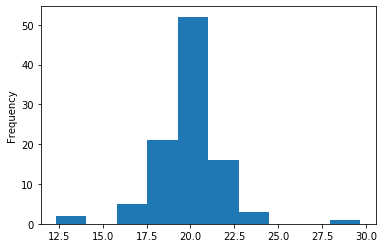

In [7]:
t_series.plot.hist(bins=10)

#### Test for normality

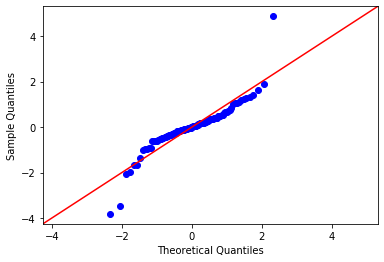

In [8]:
fig = qqplot(t_series, fit=True, line='45')
plt.show()

In [9]:
st.shapiro_wilks_(t_series)

Statistics=0.866, p=0.000
Sample does not look Gaussian (reject H0)


In [10]:
st.jarque_bera_(t_series)

Statistics=216.476, p=0.000, skew=0.138, kurt=10.203
Sample does not look Gaussian (reject H0)


#### Individual control chart

In [11]:
in_control_mean = t_series.mean()

In [12]:
MR  = cp.calculate_MR(t_series)
in_control_sigma = cp.estimate_sigma_from_MR(MR)

In [13]:
in_control_mean, in_control_sigma

(19.95653156876042, 1.7480341010350233)

In [14]:
x_ind_params = cp.x_ind_params(x = t_series, sigma = in_control_sigma, center=in_control_mean)

In [15]:
x_ind_params = x_ind_params.reset_index()

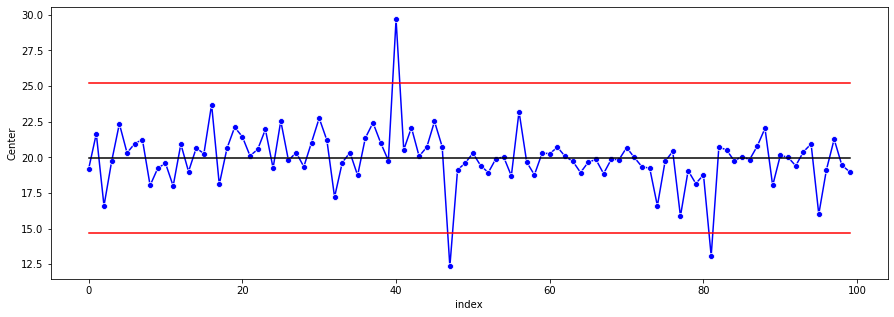

In [16]:
pf.plot_control_chart(
    data=x_ind_params,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='steps-mid',
    title=None,
    ylab=None,
    xlab=None,
    all_dates=False,
    rot=0)

#### Transform gamma dist with boxcox

In [17]:
t_series_transformed = pd.Series(boxcox(t_series)[0])

In [18]:
boxcox(t_series)[1]

1.081767938984426

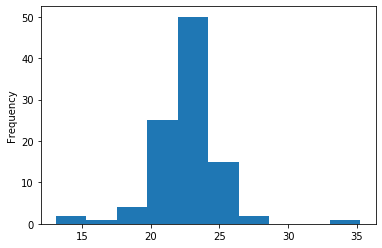

In [19]:
t_series_transformed.plot.hist()

#### Test for normality

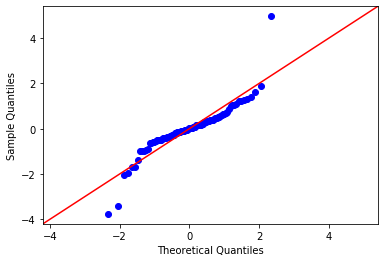

In [20]:
fig = qqplot(t_series_transformed, fit=True, line='45')
plt.show()

In [21]:
st.shapiro_wilks_(t_series_transformed)

Statistics=0.866, p=0.000
Sample does not look Gaussian (reject H0)


In [22]:
st.jarque_bera_(t_series_transformed)

Statistics=228.320, p=0.000, skew=0.249, kurt=10.386
Sample does not look Gaussian (reject H0)


#### Individual control chart (transformed)

In [23]:
in_control_mean = t_series_transformed.mean()

In [24]:
MR  = cp.calculate_MR(t_series_transformed)
in_control_sigma = cp.estimate_sigma_from_MR(MR)

In [25]:
in_control_mean, in_control_sigma

(22.6504676527644, 2.2305811568205067)

In [26]:
x_ind_params = cp.x_ind_params(x = t_series_transformed, sigma = in_control_sigma, center=in_control_mean, L=3)

In [27]:
x_ind_params = x_ind_params.reset_index()

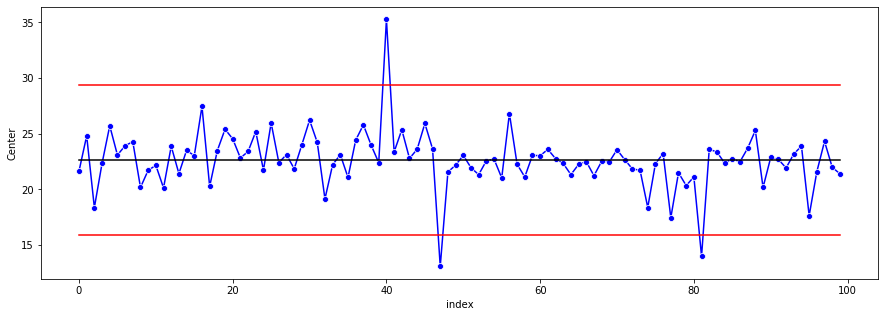

In [28]:
pf.plot_control_chart(
    data=x_ind_params,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='steps-mid',
    title=None,
    ylab=None,
    xlab=None,
    all_dates=False,
    rot=0)

#### Check probability (adjust control limits)

In [29]:
df = list(range(3, 31))

In [30]:
mean, var, skew, kurt = t.stats(df, moments='mvsk')

In [31]:
sigma1 = 1 * np.sqrt(var)
sigma2 = 2 * np.sqrt(var)
sigma3 = 3 * np.sqrt(var)
sigma4 = 4 * np.sqrt(var)
sigma5 = 5 * np.sqrt(var)
sigma6 = 6 * np.sqrt(var)

In [32]:
def coverage(CL, df):
    n_sigma = CL * t.std(df=df, loc=0, scale=1)
    ret = (1 - (1 - t.cdf(n_sigma, df=df, loc=0, scale=1)) * 2) * 100
    return ret

In [33]:
t_df = pd.DataFrame({'df':df,
                     'skew':skew,
                     'kurt':kurt,
                     'sigma1':sigma1,
                     'sigma2':sigma2,
                     'sigma3':sigma3,
                     'sigma4':sigma4,
                     'sigma5':sigma5,
                     'sigma6':sigma6,
                     'coverage1':coverage(1, df),
                     'coverage2':coverage(2, df),
                     'coverage3':coverage(3, df),
                     'coverage4':coverage(4, df),
                     'coverage5':coverage(5, df),
                     'coverage6':coverage(6, df)
                  })

In [34]:
t_df['coverage3_norm'] = (1 - (1 - norm.cdf(3)) * 2 ) * 100

In [35]:
# t_df_sub = t_df.loc[:, ['df', 'coverage1', 'coverage2', 'coverage3', 'coverage4', 'coverage5', 'coverage3_norm']]
t_df_sub = t_df.loc[:, ['df', 'coverage3', 'coverage4', 'coverage5', 'coverage6', 'coverage3_norm']]

In [36]:
t_df_sub_melt = pd.melt(t_df_sub, id_vars=['df'])

In [37]:
# t_df_sub

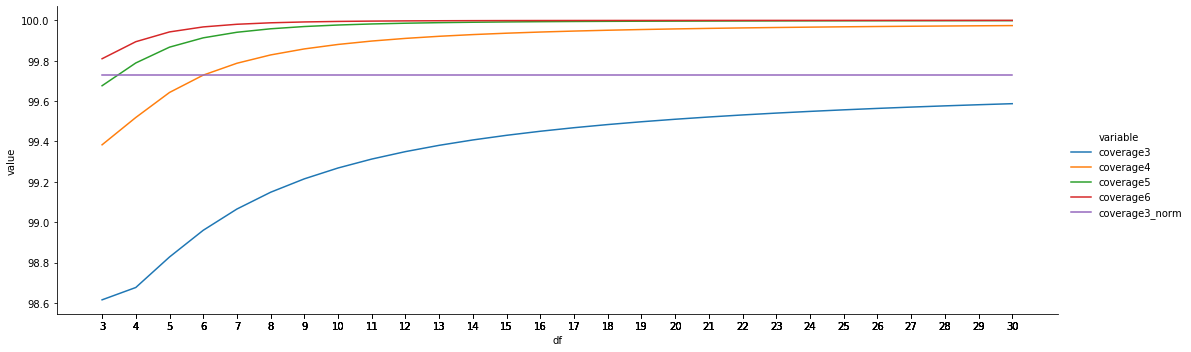

In [38]:
g = sns.relplot(x='df', y='value', hue='variable', data=t_df_sub_melt, kind='line', height=5, aspect=3)
g.set(xticks=t_df_sub_melt.df.values)